In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Covariance evolution

In [2]:
covs = []
means = []

#define parameters
gamma = 1.0 #damping from outside 
Gamma = 0.8 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?
w = 0.4 # hamornic oscillator freq mecanical
m = 1 # mass harmonic oscillator mechanical
T = 2*np.pi/w

C= np.diag([np.sqrt(4*eta*Gamma)]*2)

A = np.array([
    [0., 1/m],
    [-m*w**2, 0.]])

D = np.diag([gamma*(n + 0.5) + Gamma]*2)

## initial condition
su = n + 0.5 + Gamma/gamma
cov_in = np.diag([np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]*2)
x_in = np.array([1,0])


covs = [cov_in]
means = [x_in]
dt = 5e-4
tf = 100
tot_steps = int(tf/dt)

xi = lambda cov: np.dot(cov, ct(C)) #+ ct(Gamma_matrix)

for k in tqdm(range(tot_steps)):
    
    x = means[-1]
    cov = covs[-1]
    
    XiCov = xi(cov)

    dy = np.dot(C, x + np.dot(np.linalg.inv(C), np.random.randn(2)/np.sqrt(dt)))*dt 
    dx = np.dot(A - XiCov.dot(C), x)*dt + XiCov.dot(dy)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt
    
    covs.append(covs[-1] + dcov)
    means.append(means[-1] + dx)

100%|██████████| 200000/200000 [00:07<00:00, 26665.09it/s]


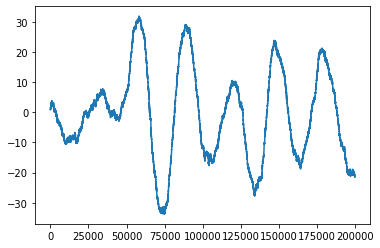

In [3]:
plt.plot([means[k][0] for k in range(len(means))])

In [50]:
class ModelA(tf.keras.Model):
    def __init__(self, target_A, seed_val=0.1 ):
        """
        Encoder network
        """
        super(ModelA,self).__init__()
        self.l1 = tf.keras.layers.Dense(32,kernel_initializer=tf.random_uniform_initializer(),bias_initializer = tf.keras.initializers.Zeros())
        self.l2 = tf.keras.layers.Dense(32,kernel_initializer=tf.random_uniform_initializer(),bias_initializer = tf.keras.initializers.Zeros())
        self.loutput = tf.keras.layers.Dense(4, bias_initializer = tf.keras.initializers.Zeros())
        self.target_A = tf.cast(A, np.float32)
        self.total_loss = Metrica(name="total_loss")

        
    def call(self, inputs):
        f = tf.nn.sigmoid(self.l1(inputs))
        f = tf.nn.sigmoid(self.l2(f))
        f = self.loutput(f)
        return f
    
    def spit_A(self):
        return tf.reshape(self(tf.ones((1,1))),(2,2))
    @property
    def metrics(self):
        """
        this helps monitring training
        """
        return [self.total_loss]

    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            A_pred = self.spit_A()
            loss = tf.keras.losses.MeanSquaredError()(A_pred,self.target_A)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss.update_state(loss)
        return {k.name:k.result() for k in self.metrics}
    
    
class Metrica(tf.keras.metrics.Metric):
    """
    This helps to monitor training (for instance each loss)
    """
    def __init__(self, name):
        super(Metrica, self).__init__()
        self._name=name
        self.metric_variable = self.add_weight(name=name, initializer='zeros')

    def update_state(self, new_value, sample_weight=None):
        self.metric_variable.assign(new_value)

    def result(self):
        return self.metric_variable

    def reset_states(self):
        self.metric_variable.assign(0.)

In [51]:
model = ModelA(target_A = A.astype(np.float64))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), loss="mse")

In [52]:
history_training =  model.fit(x=tf.random.uniform((1,100)), y=tf.random.uniform((1,100)), epochs=1000, verbose=0)

In [53]:
model.spit_A()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00],
       [-1.6000000e-01,  3.7252903e-08]], dtype=float32)>

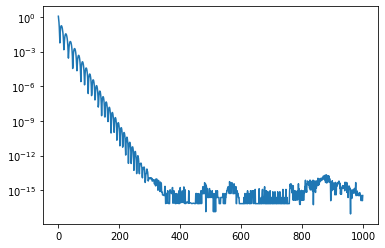

In [58]:
ax=plt.subplot2grid((1,1),(0,0))
ax.plot(history_training.history["total_loss"])
ax.set_yscale('log')